🚖 **NYC Ride-Hailing Bottlenecks: Where and When the System Fails**

**Objective:**  
Detect the hours and locations in NYC where ride-hailing marketplace performance collapses due to supply-demand imbalance.

We begin by analyzing trip **demand intensity** to reveal early patterns of stress — zones and hours where rider requests peak and the system is likely overloaded.


1️⃣ Setup

Import necessary libraries and load the April 2025 NYC Yellow Taxi dataset.


In [13]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

DATA_PATH = "/Users/gurandajeiranashvili/Desktop/Portfolio/tlctrip/yellow_tripdata_2025-04.parquet"
df = pd.read_parquet(DATA_PATH)

df.head()




,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,1,2025-04-01 00:47:06,2025-04-01 01:13:25,1.0,9.50,1.0,N,138,230,1,38.7,11.00,0.5,11.65,6.94,1.0,69.79,2.5,1.75,0.75
1,2,2025-04-01 00:27:35,2025-04-01 00:38:19,2.0,3.77,1.0,N,138,92,1,17.0,6.00,0.5,4.90,0.00,1.0,31.15,0.0,1.75,0.00
2,2,2025-04-01 00:24:07,2025-04-01 00:35:12,1.0,5.41,1.0,N,132,130,1,22.6,1.00,0.5,5.37,0.00,1.0,32.22,0.0,1.75,0.00
3,1,2025-04-01 00:56:30,2025-04-01 01:00:49,2.0,0.60,1.0,N,79,4,1,6.5,4.25,0.5,2.45,0.00,1.0,14.70,2.5,0.00,0.75
4,2,2025-04-01 00:00:17,2025-04-01 00:16:19,1.0,0.43,1.0,N,161,229,2,4.4,1.00,0.5,0.00,0.00,1.0,10.15,2.5,0.00,0.75


 2️⃣ Aggregating Trips by Zone and Hour ⏱️

To detect demand surges and delays, I group all trips by:

- 🗺️ `PULocationID` — the pickup zone  
- 🕒 `pickup_hour` — the hour of day

From this, I calculate:

- 🚕 Total number of trips in each zone per hour  
- ⏳ Average duration of these trips  
- 📏 Average distance traveled

This helps identify hotspots where trip count is high, trips take longer, or both — revealing signs of congestion or peak demand patterns.


In [10]:
# 1️⃣ Compute trip duration in minutes (once!)
df["trip_duration_min"] = (
    pd.to_datetime(df["tpep_dropoff_datetime"]) - pd.to_datetime(df["tpep_pickup_datetime"])
).dt.total_seconds() / 60

# 2️⃣ Create pickup_hour column
df["pickup_hour"] = pd.to_datetime(df["tpep_pickup_datetime"]).dt.hour

# 3️⃣ Group by pickup zone and hour, then aggregate
zone_hourly_stats = df.groupby(["PULocationID", "pickup_hour"]).agg(
    trips_per_hour=("tpep_pickup_datetime", "count"),
    avg_duration_min=("trip_duration_min", "mean"),
    avg_distance_mi=("trip_distance", "mean")
).reset_index()
# 4️⃣ Sort to find top congestion hotspots
zone_hourly_stats.sort_values("trips_per_hour", ascending=False).head(10)



,PULocationID,pickup_hour,trips_per_hour,avg_duration_min,avg_distance_mi
3495,161,18,17257,15.548833,1.878427
3494,161,17,16417,16.685410,1.990995
5164,237,17,14468,13.123514,1.681265
5162,237,15,14312,13.535166,1.713434
3498,161,21,14295,13.592607,6.609840
5001,230,22,14258,14.561630,2.408614
5165,237,18,14238,12.443073,1.647800
5161,237,14,14145,13.510965,1.735704
5163,237,16,14064,13.471326,1.674224
3496,161,19,13967,14.391505,1.967415


📈 3️⃣ Hourly Demand Patterns in Busiest NYC Zones

To uncover **where and when demand peaks**, I now visualize how the number of taxi pickups varies over the 24-hour day — focusing on the **top 3 busiest pickup zones**.

🔍 This helps identify:
- 🕕 Rush hour pressure points
- 📍 Which zones face the most consistent load
- 🚦 Potential congestion windows for intervention


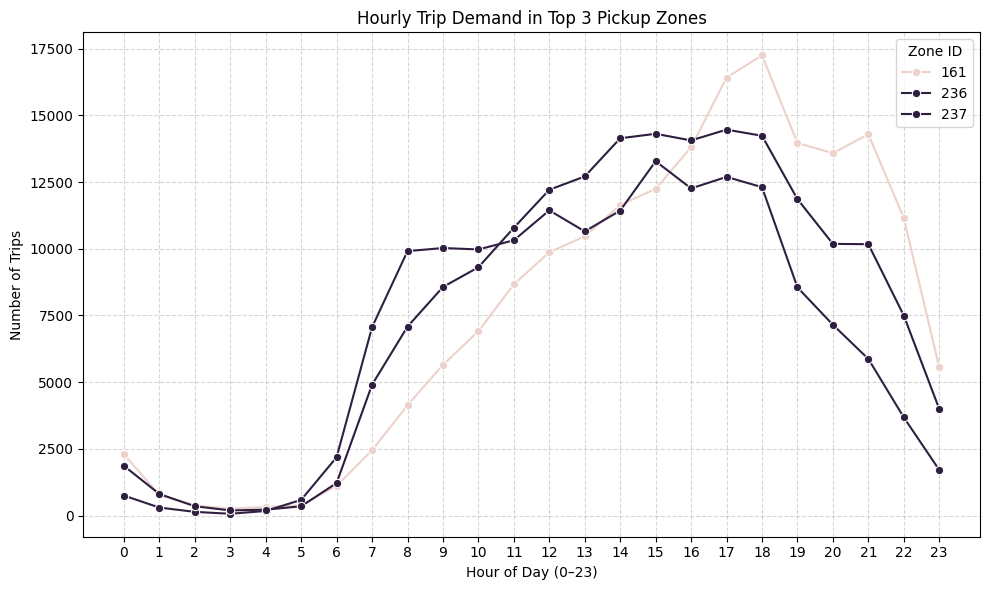

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get top 3 zones with the most total trips (across all hours)
top_zones = (
    zone_hourly_stats.groupby("PULocationID")["trips_per_hour"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index
)

# Filter data for only those zones
top_zone_data = zone_hourly_stats[zone_hourly_stats["PULocationID"].isin(top_zones)]

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=top_zone_data,
    x="pickup_hour",
    y="trips_per_hour",
    hue="PULocationID",
    marker="o"
)

plt.title("Hourly Trip Demand in Top 3 Pickup Zones")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Trips")
plt.xticks(range(0, 24))
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Zone ID")
plt.tight_layout()
plt.show()


4️⃣ Merging Zone Metadata into Hourly Statistics

To enrich our hourly taxi demand statistics with geographical context, we merge the zone information (such as zone names, boroughs, and geometries) from the NYC Taxi Zones shapefile into our hourly trip data. This allows each observation to be spatially referenced for mapping.

We perform a left join using the `LocationID` (which identifies pickup zones) to attach each trip record to its respective zone and borough. This step enables the geospatial visualization of taxi activity later in the analysis.


In [25]:
import geopandas as gpd

# Load the shapefile from the correct directory
gdf = gpd.read_file("/Users/gurandajeiranashvili/Desktop/Portfolio/tlctrip/taxi_zones/taxi_zones.shp")

#  Preview column names
print(gdf.columns)

#  Merge zone metadata into hourly stats
zone_hourly_named = pd.merge(
    zone_hourly_stats,                                # your hourly stats (must be pre-defined)
    gdf[['LocationID', 'zone', 'borough', 'geometry']],  # select only necessary columns
    left_on='PULocationID',
    right_on='LocationID',
    how='left'
)

# Preview enriched data
zone_hourly_named[['pickup_hour', 'zone', 'borough', 'trips_per_hour', 'avg_duration_min']].head()


Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough', 'geometry'], dtype='object')


,pickup_hour,zone,borough,trips_per_hour,avg_duration_min
0,0,Newark Airport,EWR,1,0.066667
1,2,Newark Airport,EWR,4,11.258333
2,3,Newark Airport,EWR,5,0.420000
3,4,Newark Airport,EWR,9,0.111111
4,5,Newark Airport,EWR,17,3.190196


 5️⃣ Visualizing Taxi Demand as a Choropleth Map

To understand where taxi services are most in demand, we aggregate the number of trips by pickup zone across all hours. We then visualize this using a choropleth map, with zones shaded according to total trip volume.

This visualization helps us identify the highest-demand locations in NYC. As expected, zones such as JFK Airport and central Manhattan exhibit the darkest shades, indicating the greatest concentration of taxi pickups. This insight is essential for transport planning, resource allocation, or policy analysis targeting urban mobility.


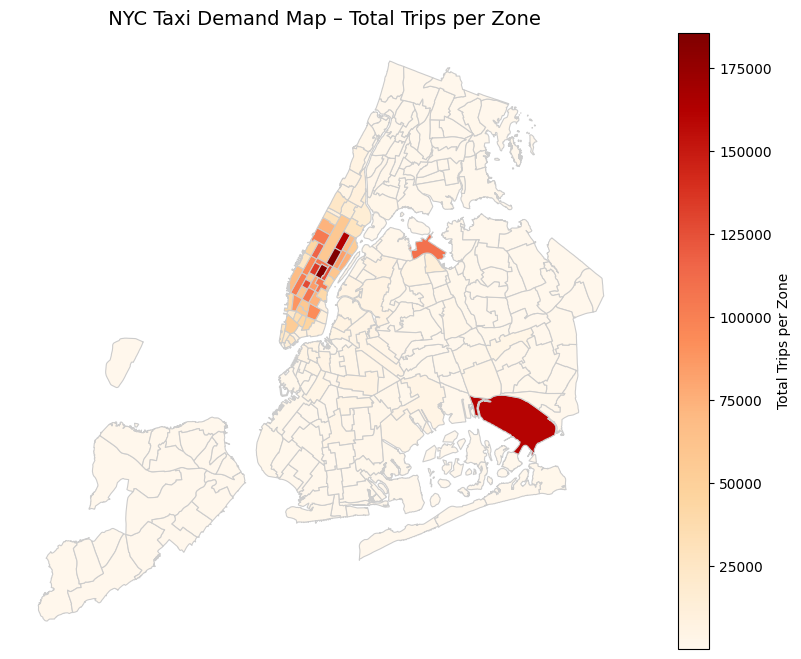

In [28]:
import matplotlib.pyplot as plt

# Merge demand into the original GeoDataFrame to preserve geometry
zone_demand = gdf.merge(
    zone_hourly_named.groupby('LocationID')[['trips_per_hour']].sum().reset_index(),
    on='LocationID',
    how='left'
)

# Plot properly
fig, ax = plt.subplots(figsize=(12, 8))
zone_demand.plot(
    column='trips_per_hour',
    cmap='OrRd',
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Total Trips per Zone"},
    ax=ax
)
ax.set_title(" NYC Taxi Demand Map – Total Trips per Zone", fontsize=14)
plt.axis("off")
plt.show()

